In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.readout import predict_downstream
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)
    
sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA10\day27
1,Z:\Data\AYAold\AYA10\day31
2,Z:\Data\AYAold\AYA10\day32
3,Z:\Data\AYAold\AYA7\day19
4,Z:\Data\AYAold\AYA7\day20
...,...
107,Z:\Data\FujisawaS\EE\EE0705fm
108,Z:\Data\FujisawaS\EE\EE0706fm
109,Z:\Data\FujisawaS\EE\EE0708fm
110,Z:\Data\HMC1\day12


In [ ]:
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\predict_downstream_pairs_v1"
# )

# batch_analysis.run(
#     df_sessions,
#     save_path,
#     predict_downstream.run,
#     parallel=True,
#     verbose=True,
# )
# # load results
# results = predict_downstream.load_results(save_path)

In [4]:
basepath = r"Z:\Data\HMC1\day8"
# basepath = r"Z:\Data\AYAold\AYA9\day14"

st, cell_metrics = loading.load_spikes(basepath,brainRegion=["CA1","PFC","MEC"])
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T]).expand(0.1)

ep_df = loading.load_epoch(basepath)
ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])

In [5]:
st = st[ep_epochs[0]]
ripple_epochs = ripple_epochs[ep_epochs[0]]

In [12]:
st_par = functions.get_participation(
    st.data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="firing_rate",
)

In [7]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Superficial")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)

In [53]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import LinearRegression, RidgeCV

X = st_par[cell_metrics.brainRegion.str.contains("MEC").values, :]
# # get pca dims that explain XX of the variance
X = PCA(n_components=0.80, svd_solver="full").fit_transform(X.T)

y = st_par[ca1_deep_idx,:][4,:]
# bad_idx = np.hstack(np.isinf(y) | np.isnan(y))
# y = y[~bad_idx]
# X = X[~bad_idx, :]

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

clf = RidgeCV().fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))


0.042625781370491334
0.008360100345581545


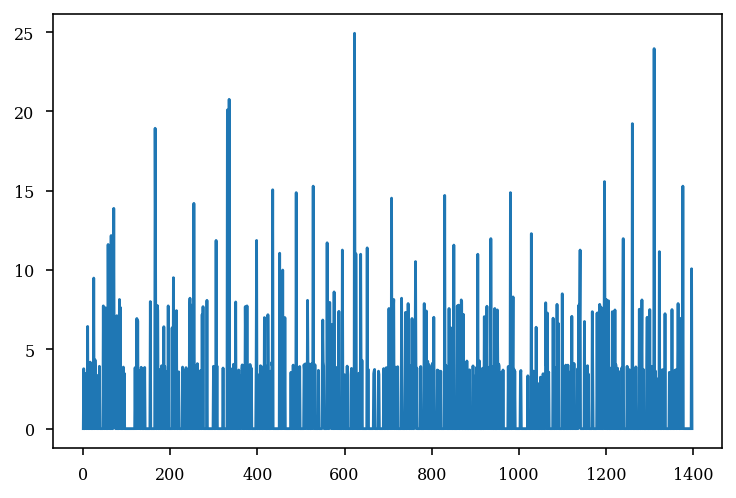

In [44]:
plt.plot(y_train)

(0.0, 50.0)

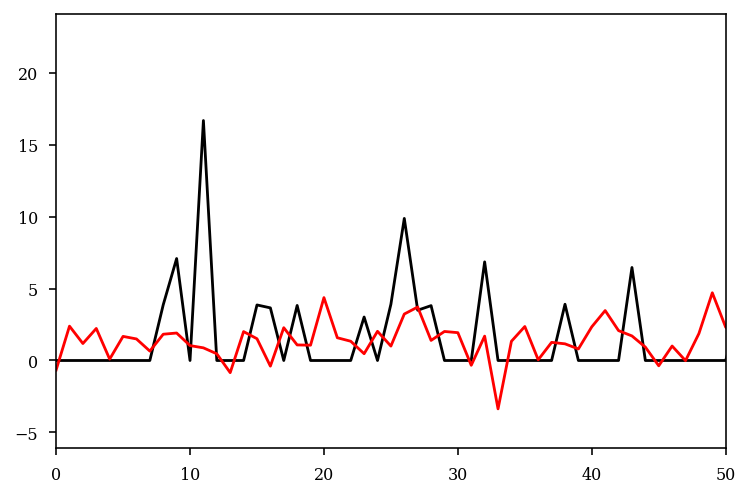

In [45]:
plt.plot(y_test,color="k")

plt.plot(clf.predict(X_test), color="red")
plt.xlim(0,50)

In [55]:
from pyglmnet import GLM

glm_poisson = GLM(distr='poisson',
                  alpha=0.05,
                  learning_rate=1.0,
                  score_metric='pseudo_R2',
                  reg_lambda=1e-7)
glm_poisson.fit(X_train, y_train)

# predict spike counts
# ypred_lg = glm_poisson.predict(X_test)

<
Distribution | poisson
alpha | 0.05
max_iter | 1000.00
lambda: 0.00
>

(0.0, 50.0)

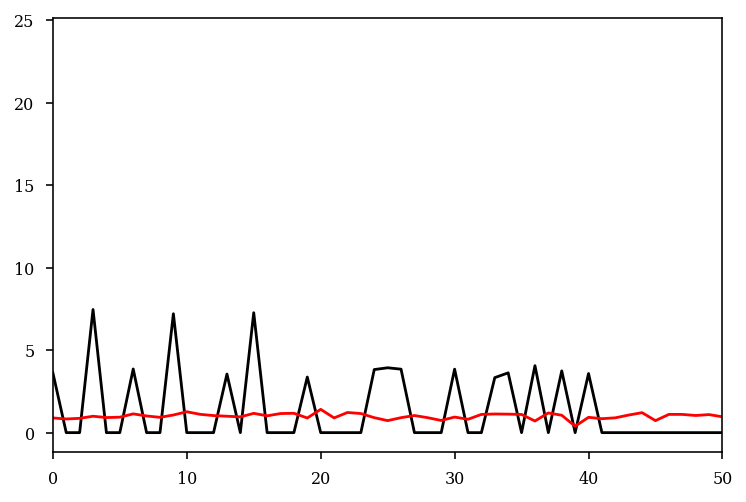

In [56]:
plt.plot(y_test,color="k")

plt.plot(glm_poisson.predict(X_test), color="red")
plt.xlim(0,50)


In [80]:
st_par.shape

(317, 2332)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    st_par[cell_metrics.brainRegion.str.contains("CA1").values,:].T, 
    st_par[cell_metrics.brainRegion.str.contains("MEC").values,:].T, test_size=0.4, random_state=42
)

In [83]:
from ripple_heterogeneity.utils import reduced_rank_regressor

REG = 10

reg = reduced_rank_regressor.ReducedRankRegressor(
    X_train,
    y_train,
    REG,
)
reg

In [84]:
from scipy import around
from scipy import size
from scipy.linalg import norm

def sqerr(matrix1, matrix2):
    """Squared error (frobenius norm of diff) between two matrices."""
    return around(pow(norm(matrix1 - matrix2, 'fro'), 2) / size(matrix2, 0), 5)

In [88]:
training_error = sqerr(reg.predict(X_train), y_train)
testing_error = sqerr(reg.predict(X_test), y_test)
training_error, testing_error

(2722.98179, 3050.74661)

<AxesSubplot:>

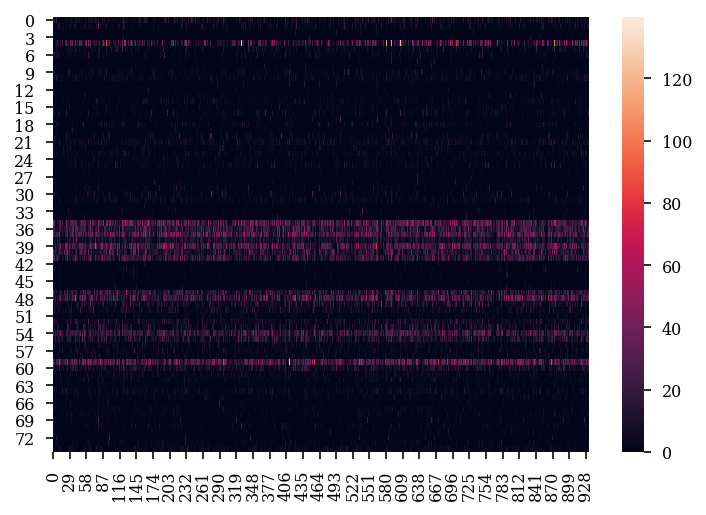

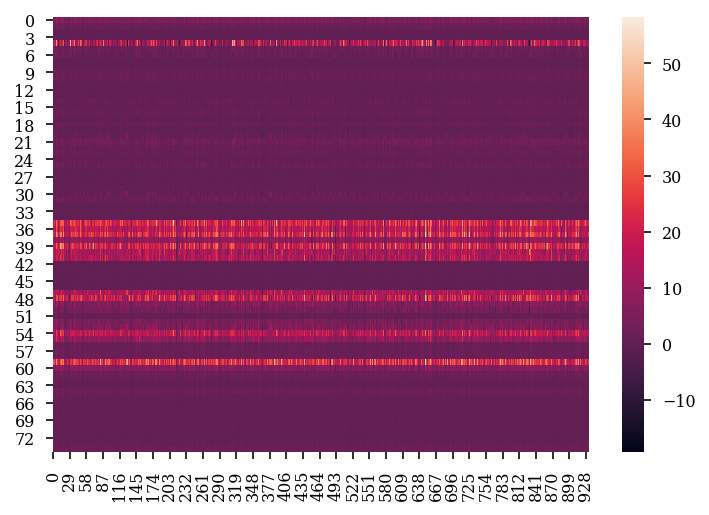

In [89]:
sns.heatmap(y_test.T)
plt.figure()
sns.heatmap(reg.predict(X_test).T)

In [59]:
loading.load_animal_behavior(r"Z:\Data\OMLproject\OML5\day8")

,time,x,y,z,linearized,speed,acceleration,epochs
0,8.894000,NaN,NaN,NaN,NaN,NaN,0.0,OML5day8_preProbe_180815_110410
1,8.902333,NaN,NaN,NaN,NaN,NaN,NaN,OML5day8_preProbe_180815_110410
2,8.910667,NaN,NaN,NaN,NaN,NaN,NaN,OML5day8_preProbe_180815_110410
3,8.919000,NaN,NaN,NaN,NaN,NaN,NaN,OML5day8_preProbe_180815_110410
4,8.927333,NaN,NaN,NaN,NaN,NaN,NaN,OML5day8_preProbe_180815_110410
...,...,...,...,...,...,...,...,...
678146,17700.309533,NaN,NaN,NaN,NaN,NaN,NaN,OML5day8_postProbe_180815_175053
678147,17700.317833,NaN,NaN,NaN,NaN,NaN,NaN,OML5day8_postProbe_180815_175053
678148,17700.326167,-102.6163,-7.1796,7.4751,NaN,NaN,NaN,OML5day8_postProbe_180815_175053
678149,17700.334500,-102.5885,-7.2071,7.4817,NaN,NaN,NaN,OML5day8_postProbe_180815_175053
